<a href="https://colab.research.google.com/github/seshadri-patra/Articulyze/blob/main/Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 0.2610 - loss: 2.0228
Epoch 1: val_accuracy improved from -inf to 0.16300, saving model to best_cifar10_resnet_model.keras
391/391 ━━━━━━━━━━━━━━━━━━━━ 90s 146ms/step - accuracy: 0.2612 - loss: 2.0222 - val_accuracy: 0.1630 - val_loss: 2.9069 - learning_rate: 0.0010
Epoch 2/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.4512 - loss: 1.5185
Epoch 2: val_accuracy improved from 0.16300 to 0.44210, saving model to best_cifar10_resnet_model.keras
391/391 ━━━━━━━━━━━━━━━━━━━━ 35s 90ms/step - accuracy: 0.4513 - loss: 1.5184 - val_accuracy: 0.4421 - val_loss: 1.6351 - learning_rate: 0.0010
Epoch 3/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.5094 - loss: 1.3756
Epoch 3: val_accuracy improved from 0.44210 to 0.48900, saving model to best_cifar10_resnet_model.keras
391/391 ━━━━━━━━━━━━━━━━━━━━ 34s 87ms/step - accuracy: 0.5094 - loss: 1.3756 - val_accuracy: 0.4890 - val_loss: 1.5639 - learning_rate: 0.0

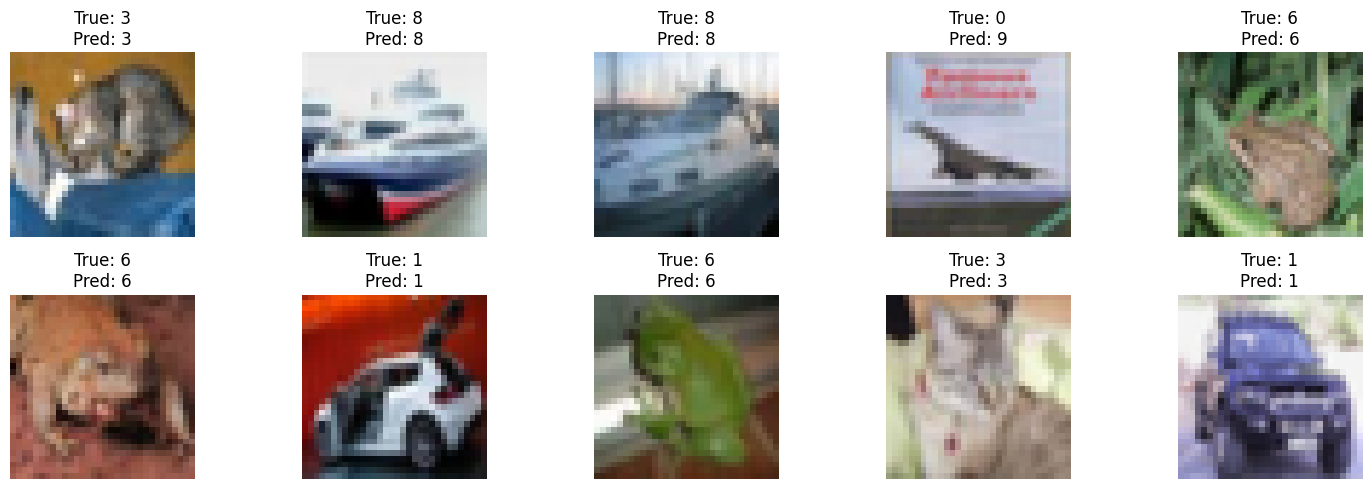

In [ ]:
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Conv2D, GlobalAveragePooling2D, Dense, Dropout, BatchNormalization, Add, Activation, Input
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt

# Load CIFAR-10 Dataset
(train_images, train_labels), (test_images, test_labels) = cifar10.load_data()

# Preprocess the data
train_images = train_images.astype('float32') / 255.0
test_images = test_images.astype('float32') / 255.0
train_mean = np.mean(train_images, axis=0)
train_images -= train_mean
test_images -= train_mean
train_labels = to_categorical(train_labels, 10)
test_labels = to_categorical(test_labels, 10)

# Residual Block function with bottleneck design
def residual_block(x, filters, strides=1):
    shortcut = x
    # First 1x1 convolution
    x = Conv2D(filters // 4, (1, 1), strides=strides, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    # 3x3 convolution
    x = Conv2D(filters // 4, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    # Second 1x1 convolution
    x = Conv2D(filters, (1, 1), padding='same')(x)
    x = BatchNormalization()(x)
    # Adjust shortcut if necessary
    if strides != 1 or shortcut.shape[-1] != filters:
        shortcut = Conv2D(filters, (1, 1), strides=strides, padding='same')(shortcut)
        shortcut = BatchNormalization()(shortcut)
    x = Add()([x, shortcut])
    x = Activation('relu')(x)
    return x

# Model Architecture
inputs = Input(shape=(32, 32, 3))
x = Conv2D(64, (3, 3), padding='same', activation='relu')(inputs)
x = BatchNormalization()(x)

# Stage 1: 64 filters
x = residual_block(x, 64)
x = residual_block(x, 64)

# Stage 2: 128 filters with downsampling
x = residual_block(x, 128, strides=2)
x = residual_block(x, 128)

# Stage 3: 256 filters with downsampling
x = residual_block(x, 256, strides=2)
x = residual_block(x, 256)

# Stage 4: 512 filters with downsampling
x = residual_block(x, 512, strides=2)
x = residual_block(x, 512)

# Global Average Pooling
x = GlobalAveragePooling2D()(x)

# Dense layers
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(10, activation='softmax')(x)

# Model definition
model = Model(inputs, outputs)

# Compile the model
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, weight_decay=0.0001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Data Augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    shear_range=0.15,
    zoom_range=0.15,
    fill_mode='nearest'
)
datagen.fit(train_images)

# Callbacks
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True, verbose=1)
checkpoint = ModelCheckpoint('best_cifar10_resnet_model.keras', monitor='val_accuracy', save_best_only=True, verbose=1)

# Model Training
history = model.fit(datagen.flow(train_images, train_labels, batch_size=128),
                    epochs=100,
                    validation_data=(test_images, test_labels),
                    callbacks=[lr_scheduler, early_stopping, checkpoint])

# Load the best model
model.load_weights('best_cifar10_resnet_model.keras')

# Final evaluation
test_loss, test_acc = model.evaluate(test_images, test_labels)
print(f'Best model test accuracy: {test_acc * 100:.2f}%')

# Visualizing Predictions with Images
def visualize_predictions(model, test_images, test_labels, num_images=10):
    predictions = model.predict(test_images[:num_images])
    predicted_classes = np.argmax(predictions, axis=1)
    true_classes = np.argmax(test_labels[:num_images], axis=1)
    plt.figure(figsize=(15, 5))
    for i in range(num_images):
        plt.subplot(2, num_images // 2, i + 1)
        plt.imshow(test_images[i] + train_mean)  # Add mean back for visualization
        plt.title(f'True: {true_classes[i]}\nPred: {predicted_classes[i]}')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Visualize predictions
visualize_predictions(model, test_images, test_labels, num_images=10)